In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data
data_train = pd.read_csv("./input/train.csv")
data_test = pd.read_csv("./input/test.csv")

# Show sample of training data
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
758,759,0,3,"Theobald, Mr. Thomas Leonard",male,34.0,0,0,363294,8.05,NaN,S
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.00,A14,S
368,369,1,3,"Jermyn, Miss. Annie",female,NaN,0,0,14313,7.75,NaN,Q


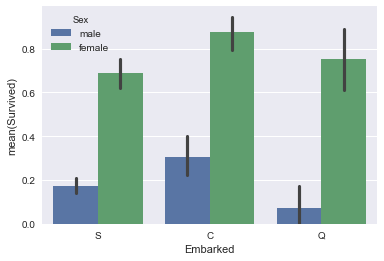

In [2]:
# Visualizing data
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train)

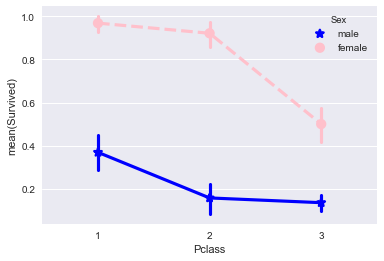

In [3]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
             palette={"male": "blue", "female": "pink"},
             markers=["*", "o"], linestyles=["-", "--"]);

In [4]:
# Transforming Features
data_train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [5]:
data_train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [6]:
# Aside from 'Sex', the 'Age' feature is second in importance. To avoid overfitting, I'm grouping people
# into logical human age groups.
# Each Cabin starts with a letter. I bet this letter is much more important than the number that follows,
# let's slice it off.
# Fare is another continuous value that should be simplified. I ran data_train.Fare.describe() to get
# the distribution of the feature, then placed them into quartile bins accordingly.
# Extract information from the 'Name' feature. Rather than use the full name, I extracted the last name
# and name prefix (Mr. Mrs. Etc.), then appended them as their own features.
# Lastly, drop useless features. (Ticket and Name)

def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ["Unknown", "Baby", "Child", "Teenager", "Student", "Young Adult",
                  "Adult", "Senior",]
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna("N")
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ["Unknown", "1_quartile", "2_quartile", "3_quartile", "4_quartile",]
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df["Lname"] = df.Name.apply(lambda x: x.split(" ")[0])
    df["NamePrefix"] = df.Name.apply(lambda x: x.split(" ")[1])
    return df

def drop_features(df):
    return df.drop(["Ticket", "Name", "Embarked"], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


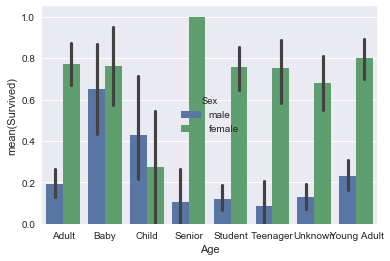

In [7]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train)

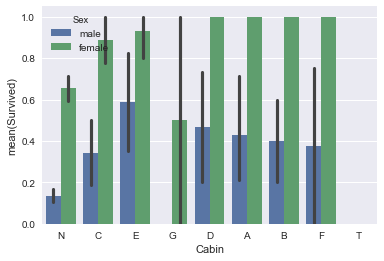

In [8]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train)

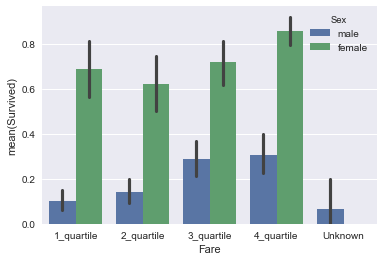

In [9]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train)

In [10]:
# Some final encoding
# The LabelEncoder in Scikit-learn will convert each unique string value into a number, making our
# data more flexible for various algorithms.
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ["Fare", "Cabin", "Age", "Sex", "Lname", "NamePrefix", ]
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [11]:
# Split up the training data
# Separate the features(X) from the labels(y).
# X_all: All features minus the value we want to predict (Survived).
# y_all: Only the value we want to predict.

X_all = data_train.drop(["Survived", "PassengerId"], axis=1)
y_all = data_train["Survived"]

# Use Scikit-learn to randomly shuffle this data into four variables. In this case, I'm training
# 80% of the data, then testing against the other 20%.
from sklearn.model_selection import train_test_split

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [13]:
# Fitting and Tuning an Algorithm
# RandomForestClassifier will be used but can also use any other such as Naive Bayes or Support Vector Machines
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifer
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {"n_estimators": [4, 6, 9],
             "max_features": ["log2", "sqrt", "auto"],
             "criterion": ["entropy", "gini"],
             "max_depth": [2, 3, 5, 10],
             "min_samples_split": [2, 3, 5],
             "min_samples_leaf": [1, 5, 8],
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [14]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.837988826816


In [20]:
# Validate with KFold
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)  # Split data into 10 buckets
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

run_kfold(clf)

Fold 1 accuracy: 0.7777777777777778
Fold 2 accuracy: 0.8651685393258427
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.8202247191011236
Fold 5 accuracy: 0.8202247191011236
Fold 6 accuracy: 0.8314606741573034
Fold 7 accuracy: 0.7752808988764045
Fold 8 accuracy: 0.797752808988764
Fold 9 accuracy: 0.8539325842696629
Fold 10 accuracy: 0.8314606741573034
Mean Accuracy: 0.8159800249687891


In [22]:
# Predict the actual test data
ids = data_test["PassengerId"]
predictions = clf.predict(data_test.drop("PassengerId", axis=1))

output = pd.DataFrame({"PassengerId": ids, "Survived": predictions})
output.to_csv("./output/titanic_predictions.csv", index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [23]:
sum(output["Survived"])

162

In [24]:
len(output)

418